# Run this code twice after the stage0 and stage0

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]='0'

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('waveglow/')

import matplotlib.pyplot as plt
%matplotlib inline

import IPython.display as ipd
import pickle as pkl
import torch
import torch.nn.functional as F
import hparams
from torch.utils.data import DataLoader
from modules.model import Model
from text import text_to_sequence, sequence_to_text
from denoiser import Denoiser
from tqdm import tqdm_notebook as tqdm
import librosa
from modules.loss import MDNLoss
import math
from multiprocessing import Pool
import numpy as np

data_type = 'char'
checkpoint_path = f"training_log/aligntts/stage0/checkpoint_40000"

from glob import glob

# checkpoint_path = sorted(glob("training_log/aligntts/stage0/checkpoint_*"))[-1]

print(checkpoint_path)


state_dict = {}
for k, v in torch.load(checkpoint_path)['state_dict'].items():
    state_dict[k[7:]]=v


model = Model(hparams).cuda()
model.load_state_dict(state_dict)
_ = model.cuda().eval()
criterion = MDNLoss()

training_log/aligntts/stage0/checkpoint_40000


In [2]:
import time

In [3]:
datasets = ['train', 'val', 'test']
batch_size=64
batch_size = 16

start = time.perf_counter()

for dataset in datasets:
    
    with open(f'filelists/ljs_audio_text_{dataset}_filelist.txt', 'r') as f:
        lines_raw = [line.split('|') for line in f.read().splitlines()]
        lines_list = [ lines_raw[batch_size*i:batch_size*(i+1)] 
                      for i in range(len(lines_raw)//batch_size+1)]
        
    for num, batch in tqdm(enumerate(lines_list)):
        
        single_loop_start = time.perf_counter()
        
        file_list, text_list, mel_list = [], [], []
        text_lengths, mel_lengths=[], []
        
        for i in range(len(batch)):
            file_name, _, text = batch[i]
            file_list.append(file_name)
            seq_path = os.path.join('../Dataset/LJSpeech-1.1/preprocessed',
                               f'{data_type}_seq')
            mel_path = os.path.join('../Dataset/LJSpeech-1.1/preprocessed',
                               'melspectrogram')
            try:
                seq = torch.from_numpy(np.load(f'{seq_path}/{file_name}_sequence.npy'))
            except FileNotFoundError:
                with open(f'{seq_path}/{file_name}_sequence.pkl', 'rb') as f:
                    seq = pkl.load(f)
            
            try:
                mel = torch.from_numpy(np.load(f'{mel_path}/{file_name}_melspectrogram.npy'))
            except FileNotFoundError:
                with open(f'{mel_path}/{file_name}_melspectrogram.pkl', 'rb') as f:
                    mel = pkl.load(f)
            
            text_list.append(seq)
            mel_list.append(mel)
            text_lengths.append(seq.size(0))
            mel_lengths.append(mel.size(1))
            
        io_time = time.perf_counter()
            
        text_lengths = torch.LongTensor(text_lengths)
        mel_lengths = torch.LongTensor(mel_lengths)
        text_padded = torch.zeros(len(batch), text_lengths.max().item(), dtype=torch.long)
        mel_padded = torch.zeros(len(batch), hparams.n_mel_channels, mel_lengths.max().item())
        
        for j in range(len(batch)):
            text_padded[j, :text_list[j].size(0)] = text_list[j]
            mel_padded[j, :, :mel_list[j].size(1)] = mel_list[j]
        
        text_padded = text_padded.cuda()
        mel_padded = mel_padded.cuda()
        text_lengths = text_lengths.cuda()
        mel_lengths = mel_lengths.cuda()
        
        with torch.no_grad():
            
            model_start = time.perf_counter()
            
            encoder_input = model.Prenet(text_padded)
            hidden_states, _ = model.FFT_lower(encoder_input, text_lengths)
            mu_sigma = model.get_mu_sigma(hidden_states)
            _, log_prob_matrix = criterion(mu_sigma, mel_padded, text_lengths, mel_lengths)
            
            viterbi_start = time.perf_counter()

            align = model.viterbi(log_prob_matrix, text_lengths, mel_lengths).to(torch.long)
            alignments = list(torch.split(align,1))
            
            viterbi_end = time.perf_counter()
        
        print('VT Time: ', end=' ')
        print(f'{viterbi_end - viterbi_start:.6f} / {viterbi_end - single_loop_start:.6f} = ' +
             f'{(viterbi_end - viterbi_start) / (viterbi_end - single_loop_start) * 100:5.2f}%')
        
        print('IO Time: ', end=' ')
        print(f'{io_time - single_loop_start:.6f} / {viterbi_end - single_loop_start:.6f} = ' +
             f'{(io_time - single_loop_start) / (viterbi_end - single_loop_start) * 100:5.2f}%')
        
        print('DL Time: ', end=' ')
        print(f'{viterbi_start - model_start:.6f} / {viterbi_end - single_loop_start:.6f} = ' +
             f'{(viterbi_start - model_start) / (viterbi_end - single_loop_start) * 100:5.2f}%')
        
#         print(alignments[0].shape)

        print()
        
        if num >= 5:
            break
       
#         for j, (l, t) in enumerate(zip(text_lengths, mel_lengths)):
#             alignments[j] = alignments[j][0, :l.item(), :t.item()].sum(dim=-1)
#             np.save(f'../Dataset/LJSpeech-1.1/preprocessed/alignments/{file_list[j]}_alignment.npy',
#                     alignments[j].detach().cpu().numpy())

VT Time:  0.328456 / 0.689838 = 47.61%
IO Time:  0.007548 / 0.689838 =  1.09%
DL Time:  0.351875 / 0.689838 = 51.01%

VT Time:  0.537944 / 0.718666 = 74.85%
IO Time:  0.006255 / 0.718666 =  0.87%
DL Time:  0.172813 / 0.718666 = 24.05%

VT Time:  0.388770 / 0.570464 = 68.15%
IO Time:  0.006215 / 0.570464 =  1.09%
DL Time:  0.173757 / 0.570464 = 30.46%

VT Time:  0.771784 / 0.955549 = 80.77%
IO Time:  0.006236 / 0.955549 =  0.65%
DL Time:  0.175656 / 0.955549 = 18.38%

VT Time:  0.281851 / 0.483085 = 58.34%
IO Time:  0.008502 / 0.483085 =  1.76%
DL Time:  0.184141 / 0.483085 = 38.12%

VT Time:  0.308661 / 0.473071 = 65.25%
IO Time:  0.006027 / 0.473071 =  1.27%
DL Time:  0.156760 / 0.473071 = 33.14%




VT Time:  0.698476 / 0.908651 = 76.87%
IO Time:  0.008725 / 0.908651 =  0.96%
DL Time:  0.199437 / 0.908651 = 21.95%

VT Time:  0.334133 / 0.487728 = 68.51%
IO Time:  0.006090 / 0.487728 =  1.25%
DL Time:  0.145989 / 0.487728 = 29.93%

VT Time:  0.330283 / 0.523225 = 63.12%
IO Time:  0.006205 / 0.523225 =  1.19%
DL Time:  0.184709 / 0.523225 = 35.30%

VT Time:  0.592178 / 0.780659 = 75.86%
IO Time:  0.006253 / 0.780659 =  0.80%
DL Time:  0.180463 / 0.780659 = 23.12%

VT Time:  0.384609 / 0.545889 = 70.46%
IO Time:  0.006090 / 0.545889 =  1.12%
DL Time:  0.153518 / 0.545889 = 28.12%

VT Time:  0.660129 / 0.862951 = 76.50%
IO Time:  0.006022 / 0.862951 =  0.70%
DL Time:  0.193690 / 0.862951 = 22.45%




VT Time:  0.340391 / 0.512507 = 66.42%
IO Time:  0.005833 / 0.512507 =  1.14%
DL Time:  0.164089 / 0.512507 = 32.02%

VT Time:  0.401949 / 0.599483 = 67.05%
IO Time:  0.006904 / 0.599483 =  1.15%
DL Time:  0.187803 / 0.599483 = 31.33%

VT Time:  0.539260 / 0.714146 = 75.51%
IO Time:  0.006417 / 0.714146 =  0.90%
DL Time:  0.165879 / 0.714146 = 23.23%

VT Time:  0.358492 / 0.550398 = 65.13%
IO Time:  0.005935 / 0.550398 =  1.08%
DL Time:  0.184229 / 0.550398 = 33.47%

VT Time:  0.661965 / 0.895034 = 73.96%
IO Time:  0.006058 / 0.895034 =  0.68%
DL Time:  0.215317 / 0.895034 = 24.06%

VT Time:  0.517605 / 0.721623 = 71.73%
IO Time:  0.006131 / 0.721623 =  0.85%
DL Time:  0.195064 / 0.721623 = 27.03%




In [4]:
datasets = ['train', 'val', 'test']
batch_size=64
batch_size = 16

start = time.perf_counter()

for dataset in datasets:
    
    with open(f'filelists/ljs_audio_text_{dataset}_filelist.txt', 'r') as f:
        lines_raw = [line.split('|') for line in f.read().splitlines()]
        lines_list = [ lines_raw[batch_size*i:batch_size*(i+1)] 
                      for i in range(len(lines_raw)//batch_size+1)]
        
    for num, batch in tqdm(enumerate(lines_list)):
        
        single_loop_start = time.perf_counter()
        
        file_list, text_list, mel_list = [], [], []
        text_lengths, mel_lengths=[], []
        
        for i in range(len(batch)):
            file_name, _, text = batch[i]
            file_list.append(file_name)
            seq_path = os.path.join('../Dataset/LJSpeech-1.1/preprocessed',
                               f'{data_type}_seq')
            mel_path = os.path.join('../Dataset/LJSpeech-1.1/preprocessed',
                               'melspectrogram')
            try:
                seq = torch.from_numpy(np.load(f'{seq_path}/{file_name}_sequence.npy'))
            except FileNotFoundError:
                with open(f'{seq_path}/{file_name}_sequence.pkl', 'rb') as f:
                    seq = pkl.load(f)
            
            try:
                mel = torch.from_numpy(np.load(f'{mel_path}/{file_name}_melspectrogram.npy'))
            except FileNotFoundError:
                with open(f'{mel_path}/{file_name}_melspectrogram.pkl', 'rb') as f:
                    mel = pkl.load(f)
            
            text_list.append(seq)
            mel_list.append(mel)
            text_lengths.append(seq.size(0))
            mel_lengths.append(mel.size(1))
            
        io_time = time.perf_counter()
            
        text_lengths = torch.LongTensor(text_lengths)
        mel_lengths = torch.LongTensor(mel_lengths)
        text_padded = torch.zeros(len(batch), text_lengths.max().item(), dtype=torch.long)
        mel_padded = torch.zeros(len(batch), hparams.n_mel_channels, mel_lengths.max().item())
        
        for j in range(len(batch)):
            text_padded[j, :text_list[j].size(0)] = text_list[j]
            mel_padded[j, :, :mel_list[j].size(1)] = mel_list[j]
        
        text_padded = text_padded.cuda()
        mel_padded = mel_padded.cuda()
        text_lengths = text_lengths.cuda()
        mel_lengths = mel_lengths.cuda()
        
        with torch.no_grad():
            
            model_start = time.perf_counter()
            
            encoder_input = model.Prenet(text_padded)
            hidden_states, _ = model.FFT_lower(encoder_input, text_lengths)
            mu_sigma = model.get_mu_sigma(hidden_states)
            _, log_prob_matrix = criterion(mu_sigma, mel_padded, text_lengths, mel_lengths)
            
            viterbi_start = time.perf_counter()

            align = model.viterbi_cpu(log_prob_matrix, text_lengths.cpu(), mel_lengths.cpu()).to(torch.long)
            alignments = list(torch.split(align,1))
            
            viterbi_end = time.perf_counter()
        
        print('VT Time: ', end=' ')
        print(f'{viterbi_end - viterbi_start:.6f} / {viterbi_end - single_loop_start:.6f} = ' +
             f'{(viterbi_end - viterbi_start) / (viterbi_end - single_loop_start) * 100:5.2f}%')
        
        print('IO Time: ', end=' ')
        print(f'{io_time - single_loop_start:.6f} / {viterbi_end - single_loop_start:.6f} = ' +
             f'{(io_time - single_loop_start) / (viterbi_end - single_loop_start) * 100:5.2f}%')
        
        print('DL Time: ', end=' ')
        print(f'{viterbi_start - model_start:.6f} / {viterbi_end - single_loop_start:.6f} = ' +
             f'{(viterbi_start - model_start) / (viterbi_end - single_loop_start) * 100:5.2f}%')
        
#         print(alignments[0].shape)

        print()
        
        if num >= 5:
            break
       
#         for j, (l, t) in enumerate(zip(text_lengths, mel_lengths)):
#             alignments[j] = alignments[j][0, :l.item(), :t.item()].sum(dim=-1)
#             np.save(f'../Dataset/LJSpeech-1.1/preprocessed/alignments/{file_list[j]}_alignment.npy',
#                     alignments[j].detach().cpu().numpy())

VT Time:  0.154995 / 0.370217 = 41.87%
IO Time:  0.006096 / 0.370217 =  1.65%
DL Time:  0.202699 / 0.370217 = 54.75%

VT Time:  0.141098 / 0.375438 = 37.58%
IO Time:  0.006999 / 0.375438 =  1.86%
DL Time:  0.220038 / 0.375438 = 58.61%

VT Time:  0.183458 / 0.367585 = 49.91%
IO Time:  0.007175 / 0.367585 =  1.95%
DL Time:  0.175275 / 0.367585 = 47.68%

VT Time:  0.188948 / 0.451633 = 41.84%
IO Time:  0.012213 / 0.451633 =  2.70%
DL Time:  0.248239 / 0.451633 = 54.96%

VT Time:  0.144518 / 0.341290 = 42.34%
IO Time:  0.006642 / 0.341290 =  1.95%
DL Time:  0.188535 / 0.341290 = 55.24%

VT Time:  0.154774 / 0.377819 = 40.97%
IO Time:  0.007465 / 0.377819 =  1.98%
DL Time:  0.208595 / 0.377819 = 55.21%




VT Time:  0.116120 / 0.275899 = 42.09%
IO Time:  0.007051 / 0.275899 =  2.56%
DL Time:  0.151035 / 0.275899 = 54.74%

VT Time:  0.115267 / 0.270026 = 42.69%
IO Time:  0.007296 / 0.270026 =  2.70%
DL Time:  0.145896 / 0.270026 = 54.03%

VT Time:  0.157664 / 0.391994 = 40.22%
IO Time:  0.007333 / 0.391994 =  1.87%
DL Time:  0.222842 / 0.391994 = 56.85%

VT Time:  0.164338 / 0.378136 = 43.46%
IO Time:  0.007392 / 0.378136 =  1.95%
DL Time:  0.204683 / 0.378136 = 54.13%

VT Time:  0.145388 / 0.355010 = 40.95%
IO Time:  0.010538 / 0.355010 =  2.97%
DL Time:  0.194228 / 0.355010 = 54.71%

VT Time:  0.170986 / 0.386790 = 44.21%
IO Time:  0.007945 / 0.386790 =  2.05%
DL Time:  0.205217 / 0.386790 = 53.06%




VT Time:  0.176422 / 0.451842 = 39.05%
IO Time:  0.008898 / 0.451842 =  1.97%
DL Time:  0.260036 / 0.451842 = 57.55%

VT Time:  0.158505 / 0.372225 = 42.58%
IO Time:  0.009028 / 0.372225 =  2.43%
DL Time:  0.202823 / 0.372225 = 54.49%

VT Time:  0.231486 / 0.468632 = 49.40%
IO Time:  0.008404 / 0.468632 =  1.79%
DL Time:  0.226909 / 0.468632 = 48.42%

VT Time:  0.151420 / 0.373891 = 40.50%
IO Time:  0.008572 / 0.373891 =  2.29%
DL Time:  0.205855 / 0.373891 = 55.06%

VT Time:  0.152578 / 0.398423 = 38.30%
IO Time:  0.006721 / 0.398423 =  1.69%
DL Time:  0.231784 / 0.398423 = 58.18%

VT Time:  0.175580 / 0.366029 = 47.97%
IO Time:  0.006845 / 0.366029 =  1.87%
DL Time:  0.181851 / 0.366029 = 49.68%




In [5]:
datasets = ['train', 'val', 'test']
batch_size=64
batch_size = 16

start = time.perf_counter()

for dataset in datasets:
    
    with open(f'filelists/ljs_audio_text_{dataset}_filelist.txt', 'r') as f:
        lines_raw = [line.split('|') for line in f.read().splitlines()]
        lines_list = [ lines_raw[batch_size*i:batch_size*(i+1)] 
                      for i in range(len(lines_raw)//batch_size+1)]
        
    for num, batch in tqdm(enumerate(lines_list)):
        
        single_loop_start = time.perf_counter()
        
        file_list, text_list, mel_list = [], [], []
        text_lengths, mel_lengths=[], []
        
        for i in range(len(batch)):
            file_name, _, text = batch[i]
            file_list.append(file_name)
            seq_path = os.path.join('../Dataset/LJSpeech-1.1/preprocessed',
                               f'{data_type}_seq')
            mel_path = os.path.join('../Dataset/LJSpeech-1.1/preprocessed',
                               'melspectrogram')
            try:
                seq = torch.from_numpy(np.load(f'{seq_path}/{file_name}_sequence.npy'))
            except FileNotFoundError:
                with open(f'{seq_path}/{file_name}_sequence.pkl', 'rb') as f:
                    seq = pkl.load(f)
            
            try:
                mel = torch.from_numpy(np.load(f'{mel_path}/{file_name}_melspectrogram.npy'))
            except FileNotFoundError:
                with open(f'{mel_path}/{file_name}_melspectrogram.pkl', 'rb') as f:
                    mel = pkl.load(f)
            
            text_list.append(seq)
            mel_list.append(mel)
            text_lengths.append(seq.size(0))
            mel_lengths.append(mel.size(1))
            
        io_time = time.perf_counter()
            
        text_lengths = torch.LongTensor(text_lengths)
        mel_lengths = torch.LongTensor(mel_lengths)
        text_padded = torch.zeros(len(batch), text_lengths.max().item(), dtype=torch.long)
        mel_padded = torch.zeros(len(batch), hparams.n_mel_channels, mel_lengths.max().item())
        
        for j in range(len(batch)):
            text_padded[j, :text_list[j].size(0)] = text_list[j]
            mel_padded[j, :, :mel_list[j].size(1)] = mel_list[j]
        
        text_padded = text_padded.cuda()
        mel_padded = mel_padded.cuda()
        text_lengths = text_lengths.cuda()
        mel_lengths = mel_lengths.cuda()
        
        with torch.no_grad():
            
            model_start = time.perf_counter()
            
            encoder_input = model.Prenet(text_padded)
            hidden_states, _ = model.FFT_lower(encoder_input, text_lengths)
            mu_sigma = model.get_mu_sigma(hidden_states)
            _, log_prob_matrix = criterion(mu_sigma, mel_padded, text_lengths, mel_lengths)
            
            viterbi_start = time.perf_counter()

#             align_ = model.fast_viterbi(log_prob_matrix, text_lengths, mel_lengths).to(log_prob_matrix.device)
#             alignments_ = list(torch.split(align_,1))
            align_cpu = model.viterbi_cpu(log_prob_matrix, text_lengths.cpu(), mel_lengths.cpu())
            alignments_cpu = list(torch.split(align_cpu,1))
            
            viterbi_end = time.perf_counter()
            
            viterbi_origin_start = time.perf_counter()

            align = model.viterbi(log_prob_matrix, text_lengths, mel_lengths).to(torch.long)
            alignments = list(torch.split(align,1))
            
            viterbi_origin_end = time.perf_counter()
            
#         print(alignments_ == alignments)
        
        print('VT_ Time: ', end=' ')
        print(f'{viterbi_origin_end - viterbi_origin_start:.6f}')
              
        print('VTF Time: ', end=' ')
        print(f'{viterbi_end - viterbi_start:.6f} / {viterbi_end - single_loop_start:.6f} = ' +
             f'{(viterbi_end - viterbi_start) / (viterbi_end - single_loop_start) * 100:5.2f}%')
       
    
        print('IO_ Time: ', end=' ')
        print(f'{io_time - single_loop_start:.6f} / {viterbi_end - single_loop_start:.6f} = ' +
             f'{(io_time - single_loop_start) / (viterbi_end - single_loop_start) * 100:5.2f}%')
        
        print('DL_ Time: ', end=' ')
        print(f'{viterbi_start - model_start:.6f} / {viterbi_end - single_loop_start:.6f} = ' +
             f'{(viterbi_start - model_start) / (viterbi_end - single_loop_start) * 100:5.2f}%')
        
        print()
        
        
        
        if num >= 5:
            break
       
#         for j, (l, t) in enumerate(zip(text_lengths, mel_lengths)):
#             alignments[j] = alignments[j][0, :l.item(), :t.item()].sum(dim=-1)
#             np.save(f'../Dataset/LJSpeech-1.1/preprocessed/alignments/{file_list[j]}_alignment.npy',
#                     alignments[j].detach().cpu().numpy())

VT_ Time:  0.748012
VTF Time:  0.154824 / 0.351953 = 43.99%
IO_ Time:  0.007186 / 0.351953 =  2.04%
DL_ Time:  0.187973 / 0.351953 = 53.41%

VT_ Time:  0.380354
VTF Time:  0.138768 / 0.315039 = 44.05%
IO_ Time:  0.006336 / 0.315039 =  2.01%
DL_ Time:  0.168183 / 0.315039 = 53.38%

VT_ Time:  0.743523
VTF Time:  0.179107 / 0.370350 = 48.36%
IO_ Time:  0.006254 / 0.370350 =  1.69%
DL_ Time:  0.182077 / 0.370350 = 49.16%

VT_ Time:  0.408704
VTF Time:  0.140108 / 0.317411 = 44.14%
IO_ Time:  0.006322 / 0.317411 =  1.99%
DL_ Time:  0.169063 / 0.317411 = 53.26%

VT_ Time:  0.762280
VTF Time:  0.150737 / 0.336098 = 44.85%
IO_ Time:  0.006118 / 0.336098 =  1.82%
DL_ Time:  0.177326 / 0.336098 = 52.76%

VT_ Time:  0.374688
VTF Time:  0.124995 / 0.289050 = 43.24%
IO_ Time:  0.006101 / 0.289050 =  2.11%
DL_ Time:  0.156331 / 0.289050 = 54.08%




VT_ Time:  0.731347
VTF Time:  0.117543 / 0.334581 = 35.13%
IO_ Time:  0.005515 / 0.334581 =  1.65%
DL_ Time:  0.209092 / 0.334581 = 62.49%

VT_ Time:  0.365710
VTF Time:  0.141810 / 0.305110 = 46.48%
IO_ Time:  0.006022 / 0.305110 =  1.97%
DL_ Time:  0.154924 / 0.305110 = 50.78%

VT_ Time:  0.550376
VTF Time:  0.165681 / 0.413121 = 40.10%
IO_ Time:  0.008668 / 0.413121 =  2.10%
DL_ Time:  0.234786 / 0.413121 = 56.83%

VT_ Time:  0.479786
VTF Time:  0.218679 / 0.387866 = 56.38%
IO_ Time:  0.006282 / 0.387866 =  1.62%
DL_ Time:  0.161252 / 0.387866 = 41.57%

VT_ Time:  0.367198
VTF Time:  0.193584 / 0.417622 = 46.35%
IO_ Time:  0.009180 / 0.417622 =  2.20%
DL_ Time:  0.208714 / 0.417622 = 49.98%

VT_ Time:  0.417315
VTF Time:  0.216851 / 0.378024 = 57.36%
IO_ Time:  0.006259 / 0.378024 =  1.66%
DL_ Time:  0.153282 / 0.378024 = 40.55%




VT_ Time:  0.386003
VTF Time:  0.177002 / 0.344754 = 51.34%
IO_ Time:  0.009012 / 0.344754 =  2.61%
DL_ Time:  0.156931 / 0.344754 = 45.52%

VT_ Time:  0.430083
VTF Time:  0.207760 / 0.370444 = 56.08%
IO_ Time:  0.006171 / 0.370444 =  1.67%
DL_ Time:  0.154863 / 0.370444 = 41.80%

VT_ Time:  0.405816
VTF Time:  0.175483 / 0.355281 = 49.39%
IO_ Time:  0.008431 / 0.355281 =  2.37%
DL_ Time:  0.169708 / 0.355281 = 47.77%

VT_ Time:  0.480949
VTF Time:  0.147155 / 0.332185 = 44.30%
IO_ Time:  0.006287 / 0.332185 =  1.89%
DL_ Time:  0.177005 / 0.332185 = 53.29%

VT_ Time:  0.630736
VTF Time:  0.150808 / 0.341883 = 44.11%
IO_ Time:  0.006284 / 0.341883 =  1.84%
DL_ Time:  0.182809 / 0.341883 = 53.47%

VT_ Time:  0.360628
VTF Time:  0.151731 / 0.339944 = 44.63%
IO_ Time:  0.006294 / 0.339944 =  1.85%
DL_ Time:  0.180163 / 0.339944 = 53.00%




In [6]:
alignments_cpu[0].shape
alignments[0].shape

torch.Size([1, 161, 863])

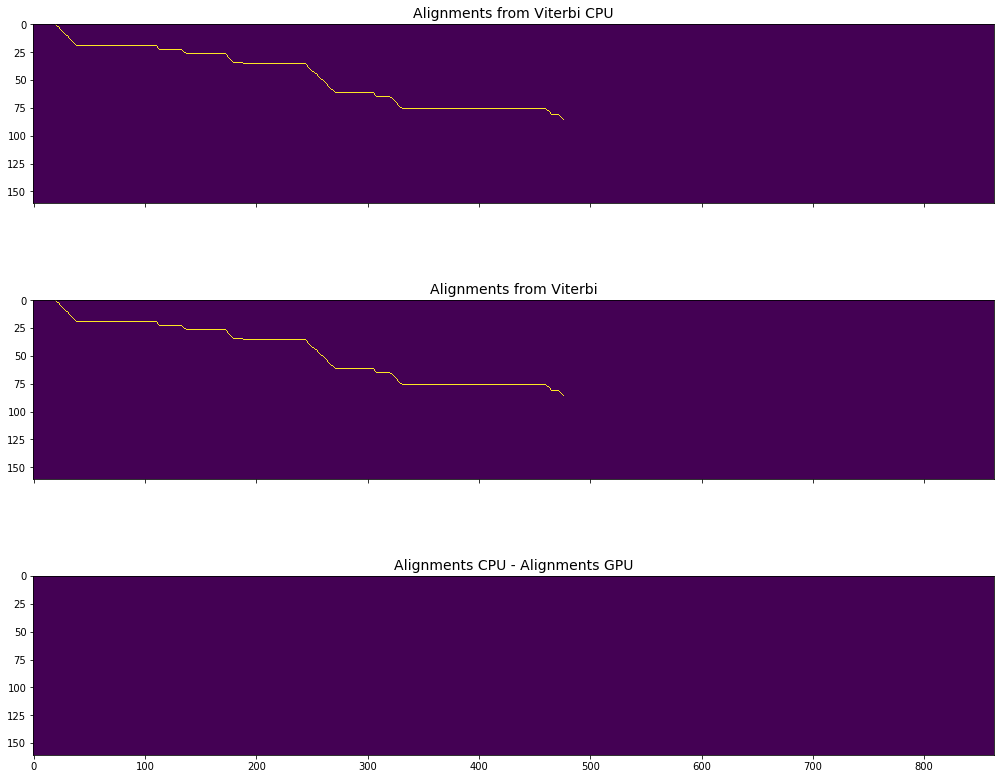

In [22]:
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex = True)

axes[0].imshow(alignments_cpu[0].cpu()[0, :, :])
axes[0].set_title('Alignments from Viterbi CPU', fontsize=14)
axes[1].imshow(alignments[0].cpu()[0, :, :])
axes[1].set_title('Alignments from Viterbi', fontsize=14)
im = axes[2].imshow(alignments_cpu[0].cpu()[0, :, :] - alignments[0].cpu()[0, :, :])
axes[2].set_title('Alignments CPU - Alignments GPU', fontsize=14)
fig.tight_layout()          
plt.show(axes[0])